In [ ]:
import warnings
warnings.filterwarnings('ignore')
# data imports
import pandas as pd
import numpy as np
from plotnine import *

# pipeline imports
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

#modeling
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline

import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_point, labs

In [ ]:
# Read in csv
data = pd.read_csv("https://raw.githubusercontent.com/dombrugi/CPSC392_Final/main/DomProjectData.csv")

# Drop missing values
data.dropna(inplace=True)

# Reset indices
data.reset_index(drop=True, inplace=True)

# Remove lower-boundary outliers
data = data[data['totalyearlycompensation'] >= 100000]

In [ ]:
# Predictors and response
X = data[['yearsofexperience', 'yearsatcompany','title', 'gender', 'Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree', 'Highschool', 'Some_College', 'Race_Asian', 'Race_White', 'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic',]]
y = data['basesalary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate numeric and categorical features
numeric_features = ['yearsofexperience', 'yearsatcompany']
categorical_features = ['title', 'gender', 'Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree', 'Highschool', 'Some_College', 'Race_Asian', 'Race_White', 'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic']

# Create a column transformer for preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a gradient boosting regressor model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))])

# Fit the transformer (OneHotEncoder) on the training data
model['preprocessor'].fit(X_train)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Output RMSE and R-squared values
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')
print('\n')

# Get feature importances
feature_importances = model.named_steps['regressor'].feature_importances_

# Output feature importances
print("Feature Importances:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")

RMSE: 43691.660672075246
R-squared: 0.20379028093604012


Feature Importances:
yearsofexperience: 0.7275409015302946
yearsatcompany: 0.05776446544241664
title: 0.013758464653759048
gender: 0.00278630242047401
Masters_Degree: 0.004185741292908865
Bachelors_Degree: 0.001587377241513981
Doctorate_Degree: 0.009888088616970346
Highschool: 0.0028195642190142283
Some_College: 0.004981342036192906
Race_Asian: 5.7277708524583283e-05
Race_White: 0.00454767388387479
Race_Two_Or_More: 0.009513515206465253
Race_Black: 0.015574179523711514
Race_Hispanic: 0.0127044564782333


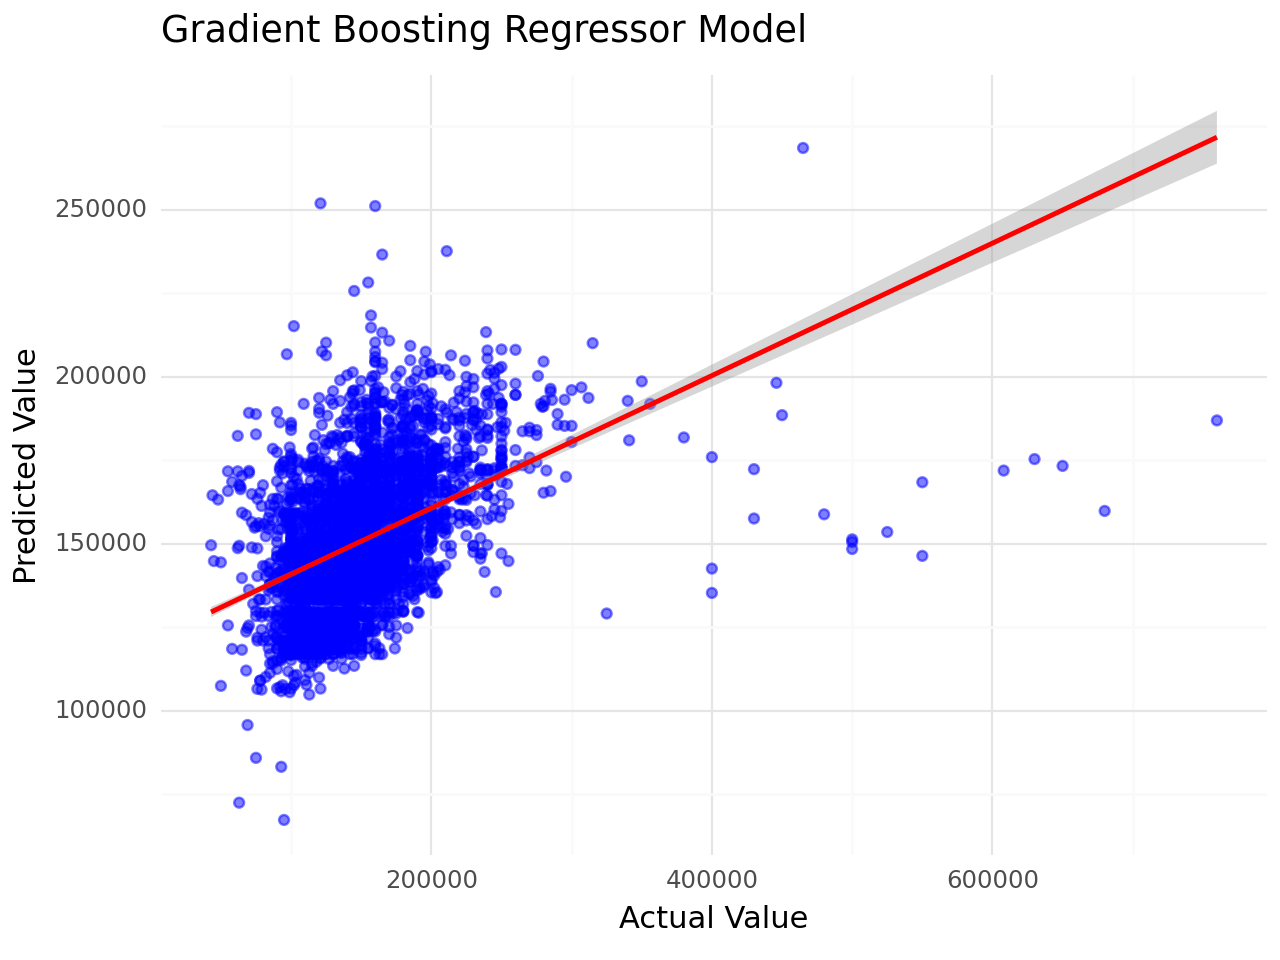

In [ ]:
# Create a dataframe for plotting
plot_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Create a ggplot for the Gradient Boosting Regressor model
chart = (
    ggplot(plot_data, aes(x='Actual', y='Predicted'))
    + geom_point(color='blue', alpha=0.5)
    + geom_smooth(method='lm', color='red')
    + theme_minimal()
    + labs(title='Gradient Boosting Regressor Model', x='Actual Value', y='Predicted Value')
)

# Display the plot
print(chart)

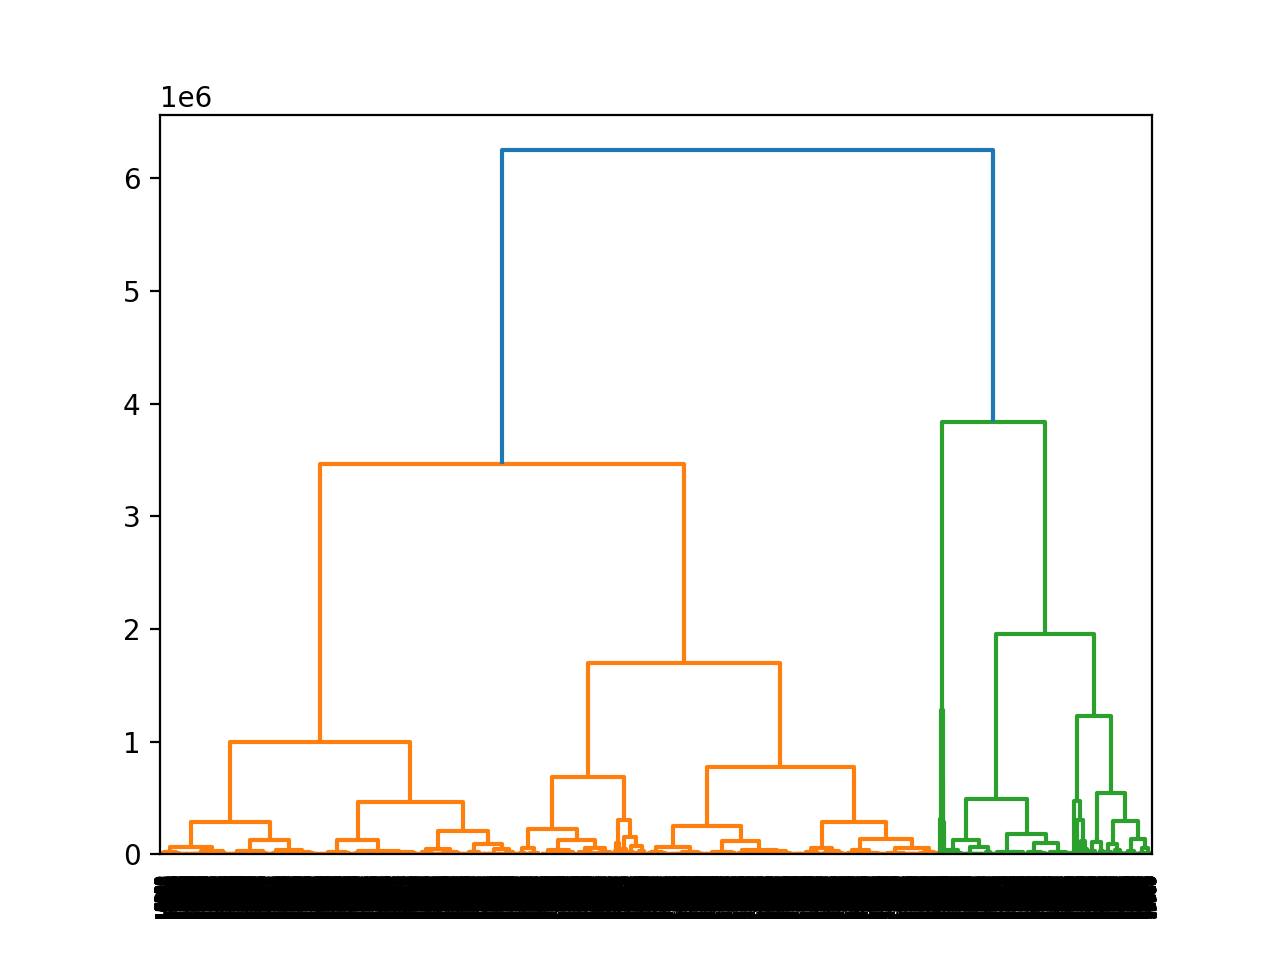

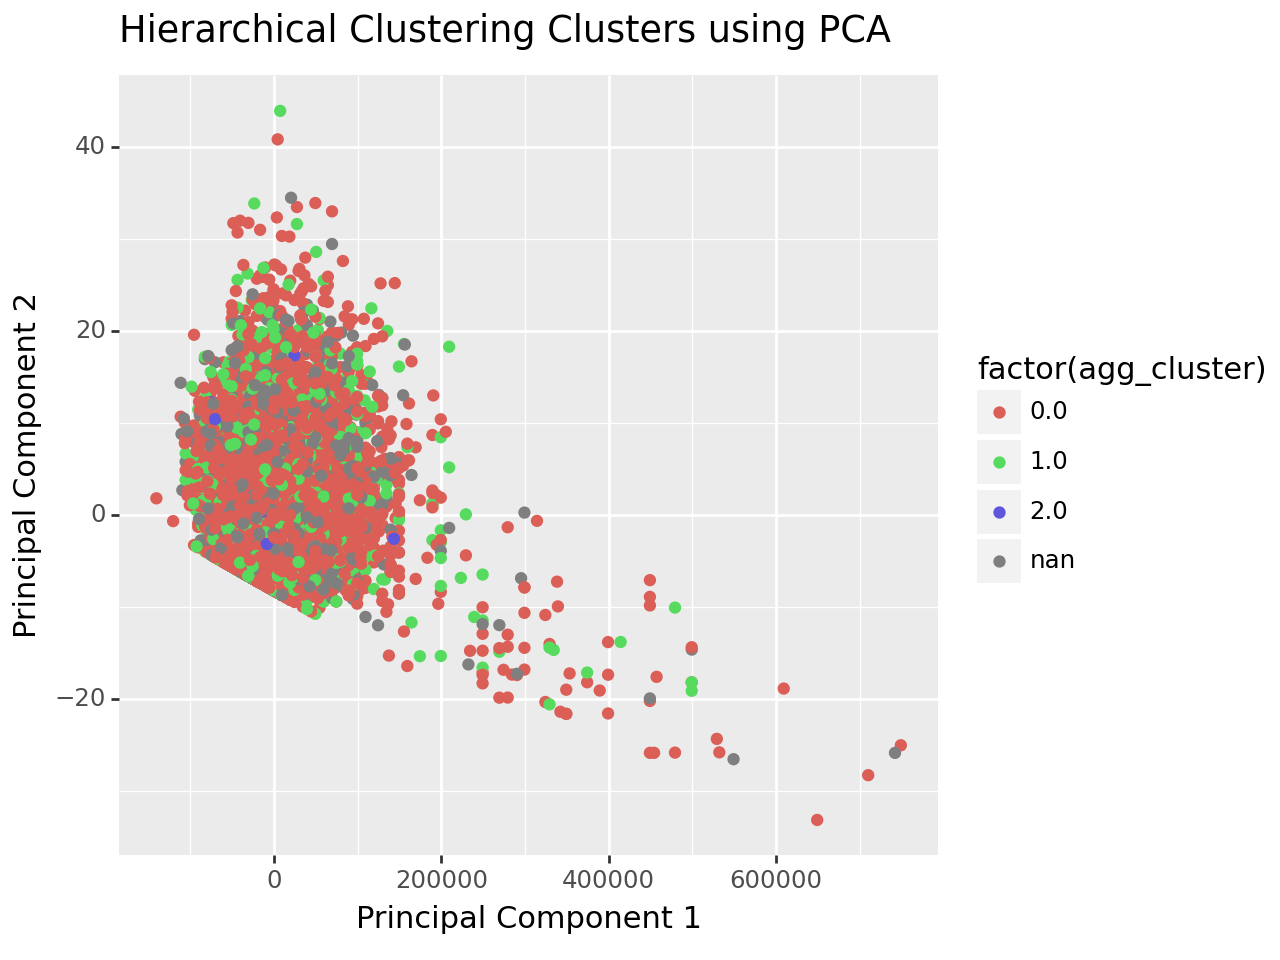

In [ ]:
# Separate continuous and categorical data
X_continuous = data[['yearsofexperience', 'yearsatcompany', 'basesalary']]
X_categorical = data[['title', 'gender', 'Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree', 'Highschool', 'Some_College']]

# Z-score continuous variables
scaler = StandardScaler()
X_continuous_scaled = scaler.fit_transform(X_continuous)

# One-hot encode categorical variables
encoder = OneHotEncoder(drop='first', sparse=False)
X_categorical_encoded = encoder.fit_transform(X_categorical)

# Combine continuous and encoded categorical variables
X_combined = np.concatenate((X_continuous_scaled, X_categorical_encoded), axis=1)

# Plot dendrogram to help choose the number of clusters
linked = linkage(X_continuous, method='ward')
dendrogram(linked)

# Apply Hierarchical Clustering
distance_metric = 'euclidean'
agg_clustering = AgglomerativeClustering(n_clusters=3, affinity=distance_metric, linkage='ward')
data['agg_cluster'] = agg_clustering.fit_predict(X_continuous)

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_continuous)
data_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
data_pca['agg_cluster'] = data['agg_cluster']

# Visualize Hierarchical Clustering clusters using PCA
cluster_plot_hierarchical = (
    ggplot(data_pca, aes(x='PC1', y='PC2', color='factor(agg_cluster)')) +
    geom_point() +
    labs(title="Hierarchical Clustering Clusters using PCA", x="Principal Component 1", y="Principal Component 2")
)
print(cluster_plot_hierarchical)

In [ ]:
# Designate columns of interest to display in summary table
columns_of_interest = ['basesalary','gender','yearsofexperience', 'yearsatcompany', 'title', 'gender', 'Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree', 'Highschool', 'Some_College', 'Race_Asian', 'Race_White', 'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic']

# Extract the columns of interest along with the cluster assignment
cluster_data = data[['agg_cluster'] + columns_of_interest]

# Compute the cluster summary
cluster_summary = cluster_data.groupby('agg_cluster').mean()

# Display the cluster summary
print(cluster_summary)

                basesalary  yearsofexperience  yearsatcompany  Masters_Degree  \
agg_cluster                                                                     
0            133363.577493           6.482587        2.562671        0.441143   
1            207931.965443          12.333693        3.968413        0.489471   
2            516468.354430          11.164557        3.088608        0.379747   

             Bachelors_Degree  Doctorate_Degree  Highschool  Some_College  \
agg_cluster                                                                 
0                    0.492229          0.039646    0.012664      0.014534   
1                    0.382829          0.091793    0.012419      0.023488   
2                    0.481013          0.088608    0.037975      0.012658   

             Race_Asian  Race_White  Race_Two_Or_More  Race_Black  \
agg_cluster                                                         
0              0.521442    0.356454          0.037128    0.032451   
1